In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.cuda.amp import autocast, GradScaler
import os

# Set environment variable to help with memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Load training data and schemas
with open('/content/drive/MyDrive/NLP/spider_data/train_spider.json', 'r') as f:
    train_data = json.load(f)

with open('/content/drive/MyDrive/NLP/spider_data/tables.json', 'r') as f:
    schemas = json.load(f)

# Create schema dictionary
schema_dict = {schema['db_id']: schema for schema in schemas}

# Function to generate schema sequence
def get_schema_sequence(db_id):
    schema = schema_dict[db_id]
    table_names = schema['table_names']
    column_names = schema['column_names']
    schema_seq = []
    for table_idx, table_name in enumerate(table_names):
        columns = [col[1] for col in column_names if col[0] == table_idx]
        schema_seq.append(f"TABLE {table_name} COLUMNS {' '.join(columns)}")
    return ' '.join(schema_seq)

# Define dataset class to return raw text
class SpiderDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        db_id = example['db_id']
        schema_seq = get_schema_sequence(db_id)
        question = example['question']
        sql = example['query']
        input_text = schema_seq + ' ' + question
        target_text = sql
        return input_text, target_text

# Custom collate function to tokenize batches
def collate_fn(batch, tokenizer):
    inputs, targets = zip(*batch)
    # Tokenize inputs
    input_encodings = tokenizer(list(inputs), padding=True, truncation=True, max_length=512, return_tensors='pt')
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(list(targets), padding=True, truncation=True, max_length=512, return_tensors='pt')
    # Replace padding token id with -100 for loss calculation
    labels = target_encodings['input_ids']
    labels[labels == tokenizer.pad_token_id] = -100
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': labels
    }

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# *** Added: Define save paths ***
model_dir = '/content/drive/MyDrive/NLP/models/t5_spider'
checkpoint_path = '/content/drive/MyDrive/NLP/models/t5_spider_checkpoint.pth'

# *** Modified: Load model and training state with checkpointing ***
if os.path.exists(checkpoint_path):
    # Load saved model and tokenizer
    model = AutoModelForSeq2SeqLM.from_pretrained(model_dir).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler = GradScaler()
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    # Load fresh T5 tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('t5-small')
    model = AutoModelForSeq2SeqLM.from_pretrained('t5-small').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler()
    start_epoch = 0

# Create DataLoader with smaller batch size
train_dataset = SpiderDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=lambda x: collate_fn(x, tokenizer), shuffle=True)

# *** Modified: Training loop with saving ***
num_epochs = 50  # Adjust as needed
for epoch in range(start_epoch, num_epochs):  # Changed to start from start_epoch
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # *** Added: Save model and checkpoint after each epoch ***
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)
    checkpoint = {
        'epoch': epoch,
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': avg_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Model saved to {model_dir}")
    print(f"Checkpoint saved to {checkpoint_path}")

# Optional: Clear GPU memory after training
torch.cuda.empty_cache()

In [2]:

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.cuda.amp import autocast, GradScaler
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# Load training data and schemas

with open('/content/drive/MyDrive/NLP/spider_data/tables.json', 'r') as f:
    schemas = json.load(f)

# Create schema dictionary
schema_dict = {schema['db_id']: schema for schema in schemas}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = '/content/drive/MyDrive/NLP/models/t5_spider'
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

def get_schema_sequence(db_id):
    schema = schema_dict[db_id]
    table_names = schema['table_names']
    column_names = schema['column_names']
    schema_seq = []
    for table_idx, table_name in enumerate(table_names):
        columns = [col[1] for col in column_names if col[0] == table_idx]
        schema_seq.append(f"TABLE {table_name} COLUMNS {' '.join(columns)}")
    return ' '.join(schema_seq)

# Use model.generate() or similar for predictions

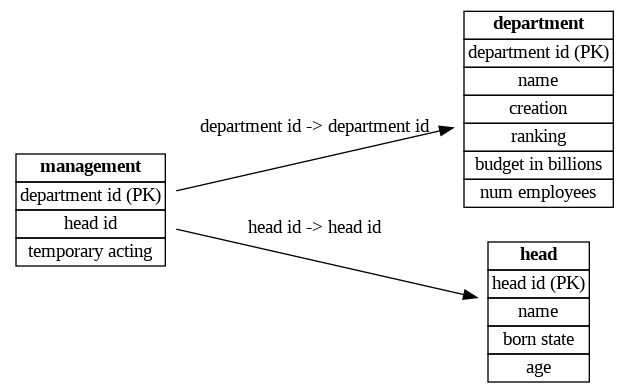

In [3]:
from graphviz import Digraph
from IPython.display import Image, display

def generate_schema_diagram(db_id, schema_dict):
    """
    Generate and display a diagram of the database schema for a given db_id.

    Args:
        db_id (str): The database identifier (e.g., 'department_management').
        schema_dict (dict): Dictionary containing schema information from tables.json.
    """
    # Extract schema for the specified database
    schema = schema_dict[db_id]

    # Create a directed graph with Graphviz
    dot = Digraph(comment=f'Schema for {db_id}')
    dot.attr(rankdir='LR')  # Left-to-right layout for better readability

    # Add nodes for each table
    for table_idx, table_name in enumerate(schema['table_names']):
        # Get all column names for this table
        columns = [col[1] for col in schema['column_names'] if col[0] == table_idx]

        # Get primary key column indices for this table
        pk_col_indices = schema['primary_keys'][table_idx] if table_idx < len(schema['primary_keys']) else []

        # Ensure pk_col_indices is always a list
        if isinstance(pk_col_indices, int):
            pk_col_indices = [pk_col_indices]  # Convert single integer to a list
        elif not isinstance(pk_col_indices, list):
            pk_col_indices = []  # Default to empty list if unexpected type

        # Get primary key column names
        pk_col_names = [schema['column_names'][col_idx][1] for col_idx in pk_col_indices if col_idx < len(schema['column_names'])]

        # Build an HTML-like label to display table name and columns
        label = f'<table border="0" cellborder="1" cellspacing="0"><tr><td><b>{table_name}</b></td></tr>'
        for col in columns:
            if col in pk_col_names:
                label += f'<tr><td>{col} (PK)</td></tr>'  # Mark primary keys
            else:
                label += f'<tr><td>{col}</td></tr>'
        label += '</table>'

        # Add the table node to the graph
        dot.node(table_name, label=f'<{label}>', shape='plaintext')

    # Add edges for foreign key relationships
    for fk in schema['foreign_keys']:
        if isinstance(fk, (list, tuple)) and len(fk) == 2:
            fk_col_idx, pk_col_idx = fk
            if fk_col_idx < len(schema['column_names']) and pk_col_idx < len(schema['column_names']):
                fk_table_idx, fk_col_name = schema['column_names'][fk_col_idx]
                pk_table_idx, pk_col_name = schema['column_names'][pk_col_idx]
                fk_table_name = schema['table_names'][fk_table_idx]
                pk_table_name = schema['table_names'][pk_table_idx]
                # Add an edge from foreign key to primary key table
                dot.edge(fk_table_name, pk_table_name, label=f"{fk_col_name} -> {pk_col_name}")
            else:
                print(f"Warning: Invalid column index in foreign key: {fk}")
        else:
            print(f"Warning: Invalid foreign key entry: {fk}")

    # Render and display the graph as a PNG in the notebook
    display(Image(dot.pipe(format='png')))

# Example usage
db_id = 'department_management'
generate_schema_diagram(db_id, schema_dict)

In [4]:
# Define the prediction function

with open('/content/drive/MyDrive/NLP/spider_data/train_spider.json', 'r') as f:
    train_data = json.load(f)

def predict(db_id, question, model, tokenizer, device):
    """
    Generate a SQL query from a natural language question and database ID.

    Args:
        db_id (str): The database identifier.
        question (str): The natural language question.
        model: The trained T5 model.
        tokenizer: The T5 tokenizer.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        str: The predicted SQL query.
    """
    model.eval()  # Set the model to evaluation mode
    schema_seq = get_schema_sequence(db_id)  # Get the schema sequence for the database
    input_text = schema_seq + ' ' + question  # Concatenate schema and question
    input_encodings = tokenizer(
        input_text,
        return_tensors='pt',  # Return PyTorch tensors
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)  # Move to the appropriate device

    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model.generate(
            input_ids=input_encodings['input_ids'],
            attention_mask=input_encodings['attention_mask'],
            max_length=512,  # Maximum length of the generated SQL query
            num_beams=4,    # Use beam search with 4 beams for better results
            early_stopping=True  # Stop when all beams reach an end token
        )

    predicted_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Decode to SQL string
    return predicted_sql

# Example usage with a training example
example = train_data[0]  # Take the first example from the training data
predicted_sql = predict(example['db_id'], example['question'], model, tokenizer, device)
print(f"Question: {example['question']}")
print(f"Predicted SQL: {predicted_sql}")
print(f"Ground Truth SQL: {example['query']}")

# Optional: Custom prediction example
custom_db_id = 'department_management'  # Replace with a valid db_id from your dataset
custom_question = 'How many heads of department are older than 56?'
predicted_sql_custom = predict(custom_db_id, custom_question, model, tokenizer, device)
print(f"\nCustom Question: {custom_question}")
print(f"Predicted SQL: {predicted_sql_custom}")
custom_db_id = 'department_management'  # Replace with a valid db_id from your dataset
custom_question = 'how many department heads are older than 56?'
predicted_sql_custom = predict(custom_db_id, custom_question, model, tokenizer, device)
print(f"\nCustom Question: {custom_question}")
print(f"Predicted SQL: {predicted_sql_custom}")

Question: How many heads of the departments are older than 56 ?
Predicted SQL: SELECT count(*) FROM head WHERE age > 56
Ground Truth SQL: SELECT count(*) FROM head WHERE age  >  56

Custom Question: How many heads of department are older than 56?
Predicted SQL: SELECT count(*) FROM head WHERE age > 56

Custom Question: how many department heads are older than 56?
Predicted SQL: SELECT count(*) FROM head WHERE age > 56


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert evaluation results (a list of dictionaries) into a DataFrame.
# We'll also compute extra columns, such as word counts for questions and lengths of SQL strings.
def show(results):
    res_df = pd.DataFrame(results)

    # Create additional columns.
    res_df['question_length'] = res_df['question'].apply(lambda x: len(x.split()))
    res_df['pred_sql_length'] = res_df['predicted_sql'].apply(lambda x: len(x.split()))
    res_df['gold_sql_length'] = res_df['gold_sql'].apply(lambda x: len(x.split()))

    # --- 1. Pie Chart: Distribution of Difficulty Levels ---
    difficulty_counts = res_df['difficulty'].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(difficulty_counts, labels=difficulty_counts.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette('pastel'))
    plt.title("Difficulty Distribution")
    plt.show()

    # --- 2. Stacked Bar Chart: Exact vs Non-Exact Matches per Difficulty ---
    # Prepare data: For each difficulty, count exact and non-exact.
    exact_df = res_df.groupby('difficulty')['exact_match'].value_counts().unstack(fill_value=0)
    exact_df = exact_df.rename(columns={True: 'Exact', False: 'Non-Exact'})
    exact_df = exact_df.loc[sorted(exact_df.index)]
    exact_df.plot(kind='bar', stacked=True, figsize=(8,6), color=['lightgreen', 'salmon'])
    plt.title("Stacked Bar: Exact vs Non-Exact Matches by Difficulty")
    plt.xlabel("Difficulty")
    plt.ylabel("Count")
    plt.legend(title="Prediction", loc='upper right')
    plt.show()

    # --- 3. Boxplot: Question Length by Difficulty ---
    plt.figure(figsize=(8,6))
    sns.boxplot(x='difficulty', y='question_length', data=res_df, palette='Set3')
    plt.title("Question Length Distribution by Difficulty (in words)")
    plt.xlabel("Difficulty Level")
    plt.ylabel("Question Length (word count)")
    plt.show()

    # --- 4. Scatter Plot: Predicted SQL Length vs. Gold SQL Length ---
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='gold_sql_length', y='pred_sql_length', hue='difficulty', style='difficulty',
                  data=res_df, palette='viridis', s=80)
    plt.title("Scatter Plot: Gold SQL Length vs. Predicted SQL Length")
    plt.xlabel("Gold SQL Length (word count)")
    plt.ylabel("Predicted SQL Length (word count)")
    plt.legend(title="Difficulty")
    plt.show()

    # --- 5. Heatmap: Correlation Matrix for Component F1 Scores ---
    # First, extract the component F1 scores from each result into their own DataFrame.
    components = ['select', 'where', 'group_by', 'order_by', 'keywords']
    # Create a DataFrame where each row corresponds to one example's component F1 scores.
    f1_data = pd.DataFrame([r['component_f1_scores'] for r in results])
    # Compute correlation matrix
    corr_matrix = f1_data[components].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title("Correlation Matrix for Component F1 Scores")
    plt.show()

    # Additional: If you want to inspect the distributions of component F1 scores across examples:
    plt.figure(figsize=(10, 6))
    f1_data[components].plot(kind='box', patch_artist=True,
                            boxprops=dict(facecolor="lightblue", color="blue"),
                            medianprops=dict(color="red"))
    plt.title("Box Plot: Distribution of Component F1 Scores")
    plt.ylabel("F1 Score")
    plt.show()


In [15]:
# Import necessary libraries
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.cuda.amp import autocast, GradScaler
import os
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

# Set environment variable to help with memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Load training data, dev data, and schemas
with open('/content/drive/MyDrive/NLP/spider_data/train_spider.json', 'r') as f:
    train_data = json.load(f)
with open('/content/drive/MyDrive/NLP/spider_data/dev.json', 'r') as f:
    dev_data = json.load(f)
with open('/content/drive/MyDrive/NLP/spider_data/tables.json', 'r') as f:
    schemas = json.load(f)

# Create schema dictionary
schema_dict = {schema['db_id']: schema for schema in schemas}

# Function to generate schema sequence
def get_schema_sequence(db_id):
    schema = schema_dict[db_id]
    table_names = schema['table_names']
    column_names = schema['column_names']
    schema_seq = []
    for table_idx, table_name in enumerate(table_names):
        columns = [col[1] for col in column_names if col[0] == table_idx]
        schema_seq.append(f"TABLE {table_name} COLUMNS {' '.join(columns)}")
    return ' '.join(schema_seq)

# Define dataset class
class SpiderDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        db_id = example['db_id']
        schema_seq = get_schema_sequence(db_id)
        question = example['question']
        sql = example['query']
        input_text = schema_seq + ' ' + question
        target_text = sql
        return input_text, target_text

# Custom collate function
def collate_fn(batch, tokenizer):
    inputs, targets = zip(*batch)
    input_encodings = tokenizer(list(inputs), padding=True, truncation=True, max_length=512, return_tensors='pt')
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(list(targets), padding=True, truncation=True, max_length=512, return_tensors='pt')
    labels = target_encodings['input_ids']
    labels[labels == tokenizer.pad_token_id] = -100
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': labels
    }

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define save paths
model_dir = '/content/drive/MyDrive/NLP/models/t5_spider'
checkpoint_path = '/content/drive/MyDrive/NLP/models/t5_spider_checkpoint.pth'

# Load or initialize model
if os.path.exists(checkpoint_path):
    model = AutoModelForSeq2SeqLM.from_pretrained(model_dir).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler = GradScaler()
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    tokenizer = AutoTokenizer.from_pretrained('t5-small')
    model = AutoModelForSeq2SeqLM.from_pretrained('t5-small').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler()
    start_epoch = 0

# Training loop (unchanged; adjust num_epochs as needed)
train_dataset = SpiderDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=lambda x: collate_fn(x, tokenizer), shuffle=True)
num_epochs = 5  # Adjust as needed

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)
    checkpoint = {
        'epoch': epoch,
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': avg_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Model and checkpoint saved.")
torch.cuda.empty_cache()

# Prediction function remains the same
def predict(db_id, question, model, tokenizer, device):
    model.eval()
    schema_seq = get_schema_sequence(db_id)
    input_text = schema_seq + ' ' + question
    input_encodings = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_encodings['input_ids'],
            attention_mask=input_encodings['attention_mask'],
            max_length=512,
            num_beams=4,
            early_stopping=True
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Custom SQL Parsing Functions (unchanged)
def normalize_sql(sql):
    sql = sql.lower()
    sql = re.sub(r'\s+', ' ', sql).strip()
    sql = re.sub(r';$', '', sql)
    sql = re.sub(r' as ([a-z0-9_]+)', '', sql)
    return sql

def extract_select_columns(sql):
    select_match = re.search(r'select\s+(.*?)(?:\s+from\s+|$)', sql, re.IGNORECASE)
    if not select_match:
        return set()
    select_clause = select_match.group(1).strip()
    columns = set()
    agg_pattern = r'(count|sum|avg|min|max|distinct)\s*\(\s*([^\)]+)\s*\)'
    for match in re.finditer(agg_pattern, select_clause, re.IGNORECASE):
        agg_func = match.group(1).lower()
        col = match.group(2).strip()
        if col == '*':
            columns.add((agg_func, '*'))
        else:
            col = col.split('.')[-1].strip()
            columns.add((agg_func, col))
    clean_clause = re.sub(agg_pattern, '', select_clause)
    for col in re.split(r',', clean_clause):
        col = col.strip()
        if col and col != '':
            if col.lower() == 'count(*)':
                columns.add(('count', '*'))
            elif col == '*':
                columns.add((None, '*'))
            elif '(' not in col:
                col = col.split('.')[-1].strip()
                if col and col != '':
                    columns.add((None, col))
    return columns

def extract_where_conditions(sql):
    where_match = re.search(r'where\s+(.*?)(?:\s+(?:group by|order by|limit|$))', sql, re.IGNORECASE)
    if not where_match:
        return set()
    where_clause = where_match.group(1).strip()
    conditions = set()
    where_clause = re.sub(r"'[^']*'", "STRING_LIT", where_clause)
    operators = {
        'eq': r'=',
        'gt': r'>',
        'lt': r'<',
        'gte': r'>=',
        'lte': r'<=',
        'neq': r'!=|<>',
        'like': r'like',
        'in': r'in',
        'not_in': r'not\s+in',
        'between': r'between'
    }
    parts = re.split(r'(\s+and\s+|\s+or\s+)', where_clause, flags=re.IGNORECASE)
    for i in range(0, len(parts), 2):
        part = parts[i].strip()
        if not part:
            continue
        for op_name, op_pattern in operators.items():
            op_match = re.search(fr'([\w\.\*]+)\s*({op_pattern})', part, re.IGNORECASE)
            if op_match:
                col = op_match.group(1).strip()
                col = col.split('.')[-1].strip()
                conditions.add((col, op_name))
                break
    for special_op in ['exists', 'not exists']:
        if re.search(fr'\b{special_op}\b', where_clause, re.IGNORECASE):
            conditions.add((None, special_op))
    return conditions

def extract_group_by_columns(sql):
    group_by_match = re.search(r'group\s+by\s+(.*?)(?:\s+(?:having|order by|limit|$))', sql, re.IGNORECASE)
    if not group_by_match:
        return set()
    group_by_clause = group_by_match.group(1).strip()
    columns = set()
    for col in re.split(r',', group_by_clause):
        col = col.strip()
        if col:
            col = col.split('.')[-1].strip()
            columns.add(col)
    return columns

def extract_order_by_columns(sql):
    order_by_match = re.search(r'order\s+by\s+(.*?)(?:\s+(?:limit|$))', sql, re.IGNORECASE)
    if not order_by_match:
        return set()
    order_by_clause = order_by_match.group(1).strip()
    columns = set()
    for item in re.split(r',', order_by_clause):
        item = item.strip()
        if not item:
            continue
        direction = 'asc'
        if re.search(r'\bdesc\b', item, re.IGNORECASE):
            direction = 'desc'
            item = re.sub(r'\s+desc\b', '', item, flags=re.IGNORECASE)
        elif re.search(r'\basc\b', item, re.IGNORECASE):
            item = re.sub(r'\s+asc\b', '', item, flags=re.IGNORECASE)
        col = item.split('.')[-1].strip()
        columns.add((col, direction))
    return columns

def extract_sql_keywords(sql):
    keywords = set()
    keyword_list = [
        'select', 'from', 'where', 'group by', 'having', 'order by',
        'limit', 'join', 'left join', 'right join', 'inner join',
        'intersect', 'except', 'union', 'exists', 'not exists'
    ]
    for keyword in keyword_list:
        if re.search(fr'\b{re.escape(keyword)}\b', sql, re.IGNORECASE):
            normalized_keyword = keyword.replace(' ', '_')
            keywords.add(normalized_keyword)
    if re.search(r'\band\b', sql, re.IGNORECASE):
        keywords.add('and')
    if re.search(r'\bor\b', sql, re.IGNORECASE):
        keywords.add('or')
    if re.search(r'\bnot\b', sql, re.IGNORECASE) and 'not_exists' not in keywords:
        keywords.add('not')
    if re.search(r'\blike\b', sql, re.IGNORECASE):
        keywords.add('like')
    if re.search(r'\bin\b', sql, re.IGNORECASE) and 'not_in' not in keywords:
        keywords.add('in')
    if re.search(r'\bnot\s+in\b', sql, re.IGNORECASE):
        keywords.add('not_in')
    return keywords

def compute_component_f1(gold_components, pred_components):
    if not gold_components and not pred_components:
        return 1.0
    if not gold_components or not pred_components:
        return 0.0
    gold_set = set(gold_components)
    pred_set = set(pred_components)
    true_positives = len(gold_set.intersection(pred_set))
    precision = true_positives / len(pred_set) if pred_set else 0
    recall = true_positives / len(gold_set) if gold_set else 0
    if precision + recall == 0:
        return 0.0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def compare_sql_components(pred_sql, gold_sql):
    norm_pred_sql = normalize_sql(pred_sql)
    norm_gold_sql = normalize_sql(gold_sql)
    pred_select = extract_select_columns(norm_pred_sql)
    gold_select = extract_select_columns(norm_gold_sql)
    pred_where = extract_where_conditions(norm_pred_sql)
    gold_where = extract_where_conditions(norm_gold_sql)
    pred_group_by = extract_group_by_columns(norm_pred_sql)
    gold_group_by = extract_group_by_columns(norm_gold_sql)
    pred_order_by = extract_order_by_columns(norm_pred_sql)
    gold_order_by = extract_order_by_columns(norm_gold_sql)
    pred_keywords = extract_sql_keywords(norm_pred_sql)
    gold_keywords = extract_sql_keywords(norm_gold_sql)
    component_matches = {
        'select': pred_select == gold_select,
        'where': pred_where == gold_where,
        'group_by': pred_group_by == gold_group_by,
        'order_by': pred_order_by == gold_order_by,
        'keywords': pred_keywords == gold_keywords
    }
    component_f1_scores = {
        'select': compute_component_f1(gold_select, pred_select),
        'where': compute_component_f1(gold_where, pred_where),
        'group_by': compute_component_f1(gold_group_by, pred_group_by),
        'order_by': compute_component_f1(gold_order_by, pred_order_by),
        'keywords': compute_component_f1(gold_keywords, pred_keywords)
    }
    return component_matches, component_f1_scores

def is_exact_match(component_matches):
    return all(component_matches.values())

def classify_sql_difficulty(sql):
    norm_sql = normalize_sql(sql)
    select_columns = extract_select_columns(norm_sql)
    where_conditions = extract_where_conditions(norm_sql)
    group_by_columns = extract_group_by_columns(norm_sql)
    order_by_columns = extract_order_by_columns(norm_sql)
    keywords = extract_sql_keywords(norm_sql)
    has_nested = norm_sql.count('select') > 1
    has_complex_ops = any(kw in keywords for kw in ['intersect', 'except', 'union'])
    join_count = sum(1 for kw in keywords if 'join' in kw)
    if has_nested or has_complex_ops or (len(select_columns) > 3 and len(where_conditions) > 3):
        return 'extra hard'
    elif (len(select_columns) > 2 and len(where_conditions) > 2) or len(group_by_columns) > 1 or has_complex_ops or join_count > 1:
        return 'hard'
    elif len(select_columns) > 1 or len(where_conditions) > 1 or len(group_by_columns) == 1 or join_count == 1:
        return 'medium'
    else:
        return 'easy'

# Evaluation function with improved presentation
# Evaluation function with improved presentation (modified results part)
def evaluate_model_pretty(model, tokenizer, dev_data, device, num_examples=None):
    model.eval()
    results = []
    if num_examples is not None:
        dev_data = dev_data[:num_examples]
    print(f"Starting evaluation on {len(dev_data)} examples...")
    for i, example in enumerate(dev_data):
        if i % 10 == 0:
            print(f"Processing example {i+1}/{len(dev_data)}")
        db_id = example['db_id']
        question = example['question']
        gold_sql = example['query']
        predicted_sql = predict(db_id, question, model, tokenizer, device)
        component_matches, component_f1_scores = compare_sql_components(predicted_sql, gold_sql)
        exact_match = is_exact_match(component_matches)
        difficulty = classify_sql_difficulty(gold_sql)
        results.append({
            'difficulty': difficulty,
            'exact_match': exact_match,
            'component_matches': component_matches,
            'component_f1_scores': component_f1_scores,
            'question': question,
            'predicted_sql': predicted_sql,
            'gold_sql': gold_sql
        })

    # Aggregate metrics
    difficulty_counts = defaultdict(int)
    difficulty_correct = defaultdict(int)
    component_counts = defaultdict(int)
    component_correct = defaultdict(int)
    component_f1_totals = defaultdict(float)
    total_queries = len(results)

    for result in results:
        diff = result['difficulty']
        difficulty_counts[diff] += 1
        if result['exact_match']:
            difficulty_correct[diff] += 1
        for comp, match in result['component_matches'].items():
            component_counts[comp] += 1
            if match:
                component_correct[comp] += 1
            component_f1_totals[comp] += result['component_f1_scores'][comp]

    # Create and display summary tables using Pandas DataFrames
    # Table 1: Exact Match Accuracy by Difficulty
    diff_summary = pd.DataFrame([
        {'Difficulty': d,
         'Count': difficulty_counts[d],
         'Exact Matches': difficulty_correct[d],
         'Accuracy': difficulty_correct[d] / difficulty_counts[d] if difficulty_counts[d] > 0 else 0}
        for d in sorted(difficulty_counts.keys())
    ])
    print("\nExact Match Accuracy by Difficulty Level:")
    display(HTML(diff_summary.to_html(index=False, float_format="{:.4f}".format)))

    # Table 2: Component Matching Accuracy
    comp_summary = pd.DataFrame([
        {'Component': c,
         'Count': component_counts[c],
         'Matches': component_correct[c],
         'Accuracy': component_correct[c] / component_counts[c] if component_counts[c] > 0 else 0}
        for c in sorted(component_counts.keys())
    ])
    print("\nComponent Matching Accuracy:")
    display(HTML(comp_summary.to_html(index=False, float_format="{:.4f}".format)))

    # Table 3: Component Average F1 Scores
    f1_summary = pd.DataFrame([
        {'Component': c,
         'Average F1': component_f1_totals[c] / component_counts[c] if component_counts[c] > 0 else 0}
        for c in sorted(component_f1_totals.keys())
    ])
    print("\nComponent Average F1 Scores:")
    display(HTML(f1_summary.to_html(index=False, float_format="{:.4f}".format)))

    overall_exact_match = sum(1 for r in results if r['exact_match']) / total_queries
    print(f"\nOverall Exact Match Accuracy: {overall_exact_match:.4f} ({sum(1 for r in results if r['exact_match'])}/{total_queries})\n")

    # Improved Plotting: Combine the three charts into one figure with subplots
    difficulties = sorted(difficulty_counts.keys())
    acc_values = [difficulty_correct[d] / difficulty_counts[d] if difficulty_counts[d] > 0 else 0 for d in difficulties]

    components = sorted(component_counts.keys())
    comp_acc_values = [component_correct[c] / component_counts[c] if component_counts[c] > 0 else 0 for c in components]
    comp_f1_values = [component_f1_totals[c] / component_counts[c] if component_counts[c] > 0 else 0 for c in components]

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Subplot 1: Exact Match Accuracy by Difficulty
    axs[0].bar(difficulties, acc_values, color='skyblue')
    axs[0].set_title('Exact Match Accuracy by Difficulty')
    axs[0].set_xlabel('Difficulty Level')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim(0, 1)
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)
    for idx, value in enumerate(acc_values):
        axs[0].text(idx, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

    # Subplot 2: Component Matching Accuracy
    axs[1].bar(components, comp_acc_values, color='lightgreen')
    axs[1].set_title('Component Matching Accuracy')
    axs[1].set_xlabel('SQL Component')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)
    for idx, value in enumerate(comp_acc_values):
        axs[1].text(idx, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

    # Subplot 3: Component Average F1 Scores
    axs[2].bar(components, comp_f1_values, color='coral')
    axs[2].set_title('Component Average F1 Scores')
    axs[2].set_xlabel('SQL Component')
    axs[2].set_ylabel('Average F1')
    axs[2].set_ylim(0, 1)
    axs[2].grid(axis='y', linestyle='--', alpha=0.7)
    for idx, value in enumerate(comp_f1_values):
        axs[2].text(idx, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Create a detailed predictions DataFrame for a quick review (showing key fields)
    pred_details = pd.DataFrame([{
        'Difficulty': r['difficulty'],
        'Exact Match': r['exact_match'],
        'Question': r['question'],
        'Predicted SQL': r['predicted_sql'],
        'Gold SQL': r['gold_sql']
    } for r in results])

    # Optionally, sort by difficulty or filter for errors
    print("\nDetailed Prediction Results:")
    display(HTML(pred_details.to_html(index=False)))

    return results

def evaluate_model_pretty2(model, tokenizer, dev_data, device, num_examples=None):
    model.eval()
    results = []
    if num_examples is not None:
        dev_data = dev_data[:num_examples]
    print(f"Starting evaluation on {len(dev_data)} examples...")
    for i, example in enumerate(dev_data):
        if i % 10 == 0:
            print(f"Processing example {i+1}/{len(dev_data)}")
        db_id = example['db_id']
        question = example['question']
        gold_sql = example['query']
        predicted_sql = predict(db_id, question, model, tokenizer, device)
        component_matches, component_f1_scores = compare_sql_components(predicted_sql, gold_sql)
        exact_match = is_exact_match(component_matches)
        difficulty = classify_sql_difficulty(gold_sql)
        results.append({
            'difficulty': difficulty,
            'exact_match': exact_match,
            'component_matches': component_matches,
            'component_f1_scores': component_f1_scores,
            'question': question,
            'predicted_sql': predicted_sql,
            'gold_sql': gold_sql
        })

    # Aggregate metrics
    difficulty_counts = defaultdict(int)
    difficulty_correct = defaultdict(int)
    component_counts = defaultdict(int)
    component_correct = defaultdict(int)
    component_f1_totals = defaultdict(float)
    total_queries = len(results)

    for result in results:
        diff = result['difficulty']
        difficulty_counts[diff] += 1
        if result['exact_match']:
            difficulty_correct[diff] += 1
        for comp, match in result['component_matches'].items():
            component_counts[comp] += 1
            if match:
                component_correct[comp] += 1
            component_f1_totals[comp] += result['component_f1_scores'][comp]

    # Create and display summary tables using Pandas DataFrames
    # Table 1: Exact Match Accuracy by Difficulty
    diff_summary = pd.DataFrame([
        {'Difficulty': d,
         'Count': difficulty_counts[d],
         'Exact Matches': difficulty_correct[d],
         'Accuracy': difficulty_correct[d] / difficulty_counts[d] if difficulty_counts[d] > 0 else 0}
        for d in ['easy', 'medium', 'hard', 'extra hard'] if d in difficulty_counts
    ])
    print("\nExact Match Accuracy by Difficulty Level:")
    display(HTML(diff_summary.to_html(index=False, float_format="{:.4f}".format)))

    # Table 2: Component Matching Accuracy
    comp_summary = pd.DataFrame([
        {'Component': c,
         'Count': component_counts[c],
         'Matches': component_correct[c],
         'Accuracy': component_correct[c] / component_counts[c] if component_counts[c] > 0 else 0}
        for c in sorted(component_counts.keys())
    ])
    print("\nComponent Matching Accuracy:")
    display(HTML(comp_summary.to_html(index=False, float_format="{:.4f}".format)))

    # Table 3: Component Average F1 Scores
    f1_summary = pd.DataFrame([
        {'Component': c,
         'Average F1': component_f1_totals[c] / component_counts[c] if component_counts[c] > 0 else 0}
        for c in sorted(component_f1_totals.keys())
    ])
    print("\nComponent Average F1 Scores:")
    display(HTML(f1_summary.to_html(index=False, float_format="{:.4f}".format)))

    overall_exact_match = sum(1 for r in results if r['exact_match']) / total_queries
    print(f"\nOverall Exact Match Accuracy: {overall_exact_match:.4f} ({sum(1 for r in results if r['exact_match'])}/{total_queries})\n")

    # Enhanced visualizations
    # Set a consistent color palette and style
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.tab10.colors

    # 1. Difficulty distribution pie chart
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    difficulty_labels = ['easy', 'medium', 'hard', 'extra hard']
    difficulty_values = [difficulty_counts.get(d, 0) for d in difficulty_labels]
    explode = (0.1, 0.05, 0.05, 0.1)  # Explode the first and last slice
    plt.pie(difficulty_values, labels=difficulty_labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[colors[i] for i in range(4)])
    plt.title('Distribution of Query Difficulty')

    # 2. Exact match accuracy by difficulty level as bar chart
    plt.subplot(2, 2, 2)
    difficulties = ['easy', 'medium', 'hard', 'extra hard']
    acc_values = [difficulty_correct.get(d, 0) / difficulty_counts.get(d, 1) for d in difficulties]
    bars = plt.bar(difficulties, acc_values, color=[colors[i] for i in range(4)])
    plt.xlabel('Difficulty Level')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Exact Match Accuracy by Difficulty')
    plt.ylim(0, 1)
    # Add data labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom')

    # 3. Component matching accuracy as radar chart
    components = sorted(component_counts.keys())
    comp_acc_values = [component_correct[c] / component_counts[c] if component_counts[c] > 0 else 0 for c in components]
    comp_f1_values = [component_f1_totals[c] / component_counts[c] if component_counts[c] > 0 else 0 for c in components]

    plt.subplot(2, 2, 3)
    # Number of variables
    N = len(components)
    # Compute angles for the radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Add values for radar plot and close the loop
    acc_values_radar = comp_acc_values + [comp_acc_values[0]]
    f1_values_radar = comp_f1_values + [comp_f1_values[0]]

    # Setup radar chart
    ax = plt.subplot(2, 2, 3, polar=True)
    # Plot accuracy values
    ax.plot(angles, acc_values_radar, 'o-', linewidth=2, label='Accuracy', color=colors[0])
    ax.fill(angles, acc_values_radar, alpha=0.25, color=colors[0])
    # Plot F1 values
    ax.plot(angles, f1_values_radar, 'o-', linewidth=2, label='F1 Score', color=colors[1])
    ax.fill(angles, f1_values_radar, alpha=0.25, color=colors[1])

    # Set labels and positions
    plt.xticks(angles[:-1], components)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=8)
    plt.ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Component Performance Metrics')

    # 4. Error analysis: Stacked bar chart showing accuracy by component and difficulty
    plt.subplot(2, 2, 4)
    # Create a dataframe for the stacked bar chart
    data = []
    for diff in ['easy', 'medium', 'hard', 'extra hard']:
        if diff not in difficulty_counts:
            continue
        diff_results = [r for r in results if r['difficulty'] == diff]
        for comp in components:
            correct = sum(1 for r in diff_results if r['component_matches'][comp])
            total = len(diff_results)
            data.append({
                'Difficulty': diff,
                'Component': comp,
                'Accuracy': correct / total if total > 0 else 0
            })

    # Create DataFrame and pivot for stacked bar chart
    df = pd.DataFrame(data)
    pivot_df = df.pivot(index='Component', columns='Difficulty', values='Accuracy')

    # Plot stacked bars
    pivot_df.plot(kind='bar', stacked=False, ax=plt.gca(),
                  color=[colors[i] for i in range(len(pivot_df.columns))], alpha=0.7)
    plt.title('Component Accuracy by Difficulty')
    plt.xlabel('Component')
    plt.ylabel('Accuracy')
    plt.legend(title='Difficulty')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # 5. Example-level visualization: Confusion matrix of components
    plt.figure(figsize=(10, 8))
    # Create matrix of True/False values for each component
    comp_results = np.zeros((len(results), len(components)))
    for i, result in enumerate(results):
        for j, comp in enumerate(components):
            comp_results[i, j] = int(result['component_matches'][comp])

    # Calculate correlation matrix
    corr_matrix = np.corrcoef(comp_results.T)

    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
                xticklabels=components, yticklabels=components, vmin=-1, vmax=1)
    plt.title('Component Success Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # 6. Error distribution visualization
    plt.figure(figsize=(10, 6))
    # Count of errors by component
    error_counts = {c: component_counts[c] - component_correct[c] for c in components}
    sorted_comps = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)
    comp_names = [c[0] for c in sorted_comps]
    error_vals = [c[1] for c in sorted_comps]

    bars = plt.bar(comp_names, error_vals, color=colors[3])
    plt.xlabel('SQL Component')
    plt.ylabel('Error Count')
    plt.title('Distribution of Errors by SQL Component')
    plt.xticks(rotation=45, ha='right')

    # Add data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Create a detailed predictions DataFrame for a quick review (showing key fields)
    # Add color highlighting for correct/incorrect predictions
    # Create a detailed predictions DataFrame for a quick review
    pred_details = pd.DataFrame([{
        'Difficulty': r['difficulty'],
        'Exact Match': r['exact_match'],
        'Question': r['question'],
        'Predicted SQL': r['predicted_sql'],
        'Gold SQL': r['gold_sql']
    } for r in results])

    # Optionally, sort by difficulty or filter for errors
    print("\nDetailed Prediction Results:")
    display(HTML(pred_details.to_html(index=False)))

    return results

# Run evaluation with improved presentation

def evaluate_model_pretty3(model, tokenizer, dev_data, device, num_examples=None):
    model.eval()
    results = []
    if num_examples is not None:
        dev_data = dev_data[:num_examples]
    print(f"Starting evaluation on {len(dev_data)} examples...")

    for i, example in enumerate(dev_data):
        if i % 10 == 0:
            print(f"Processing example {i+1}/{len(dev_data)}")
        db_id = example['db_id']
        question = example['question']
        gold_sql = example['query']
        predicted_sql = predict(db_id, question, model, tokenizer, device)
        component_matches, component_f1_scores = compare_sql_components(predicted_sql, gold_sql)
        exact_match = is_exact_match(component_matches)
        difficulty = classify_sql_difficulty(gold_sql)
        results.append({
            'difficulty': difficulty,
            'exact_match': exact_match,
            'component_matches': component_matches,
            'component_f1_scores': component_f1_scores,
            'question': question,
            'predicted_sql': predicted_sql,
            'gold_sql': gold_sql
        })

    # Aggregate metrics
    difficulty_counts = defaultdict(int)
    difficulty_correct = defaultdict(int)
    component_counts = defaultdict(int)
    component_correct = defaultdict(int)
    component_f1_totals = defaultdict(float)
    total_queries = len(results)

    for result in results:
        diff = result['difficulty']
        difficulty_counts[diff] += 1
        if result['exact_match']:
            difficulty_correct[diff] += 1
        for comp, match in result['component_matches'].items():
            component_counts[comp] += 1
            if match:
                component_correct[comp] += 1
            component_f1_totals[comp] += result['component_f1_scores'][comp]

    # Overall accuracy
    overall_exact_match = sum(1 for r in results if r['exact_match']) / total_queries
    print(f"\nOverall Exact Match Accuracy: {overall_exact_match:.4f} ({sum(1 for r in results if r['exact_match'])}/{total_queries})\n")

    # Visualization 1: Exact Match Accuracy by Difficulty
    plt.figure(figsize=(12, 8))

    difficulties = ['easy', 'medium', 'hard', 'extra hard']
    difficulties = [d for d in difficulties if d in difficulty_counts]
    acc_values = [difficulty_correct.get(d, 0) / difficulty_counts.get(d, 1) for d in difficulties]
    counts = [difficulty_counts.get(d, 0) for d in difficulties]

    plt.subplot(2, 2, 1)
    bars = plt.bar(difficulties, acc_values, color='skyblue')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Accuracy by Difficulty Level')
    plt.ylim(0, 1)

    # Add count and accuracy as labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f"{height:.2f}\n({counts[i]})", ha='center', va='bottom')

    # Visualization 2: Component Accuracy
    components = sorted(component_counts.keys())
    comp_acc_values = [component_correct[c] / component_counts[c] if component_counts[c] > 0 else 0 for c in components]

    plt.subplot(2, 2, 2)
    bars = plt.bar(components, comp_acc_values, color='lightgreen')
    plt.xlabel('SQL Component')
    plt.ylabel('Matching Accuracy')
    plt.title('Component Matching Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f"{height:.2f}", ha='center', va='bottom')

    # Visualization 3: Component F1 Scores
    comp_f1_values = [component_f1_totals[c] / component_counts[c] if component_counts[c] > 0 else 0 for c in components]

    plt.subplot(2, 2, 3)
    bars = plt.bar(components, comp_f1_values, color='coral')
    plt.xlabel('SQL Component')
    plt.ylabel('Average F1 Score')
    plt.title('Component F1 Scores')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f"{height:.2f}", ha='center', va='bottom')

    # Visualization 4: Error distribution
    plt.subplot(2, 2, 4)
    error_counts = {c: component_counts[c] - component_correct[c] for c in components}
    errors = [error_counts[c] for c in components]

    bars = plt.bar(components, errors, color='salmon')
    plt.xlabel('SQL Component')
    plt.ylabel('Number of Errors')
    plt.title('Error Distribution by Component')
    plt.xticks(rotation=45, ha='right')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f"{int(height)}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Create a simple text-based results table
    print("\nDetailed Prediction Results:")
    print("=" * 100)
    print(f"{'ID':<4}{'Difficulty':<12}{'Match':<8}{'Question':<40}{'Predicted SQL':<50}{'Gold SQL':<50}")
    print("-" * 100)

    for i, r in enumerate(results[:20]):  # Show first 20 examples
        # Truncate long text fields
        q_trunc = r['question'][:37] + "..." if len(r['question']) > 37 else r['question']
        p_trunc = r['predicted_sql'][:47] + "..." if len(r['predicted_sql']) > 47 else r['predicted_sql']
        g_trunc = r['gold_sql'][:47] + "..." if len(r['gold_sql']) > 47 else r['gold_sql']

        # Print with formatting
        match_str = "✓" if r['exact_match'] else "✗"
        print(f"{i:<4}{r['difficulty']:<12}{match_str:<8}{q_trunc:<40}{p_trunc:<50}{g_trunc:<50}")

    print("=" * 100)

    # Create tables for error analysis using pandas
    print("\nCreating a CSV file with full results for further analysis...")
    results_df = pd.DataFrame([{
        'ID': i,
        'Difficulty': r['difficulty'],
        'Exact_Match': r['exact_match'],
        'Question': r['question'],
        'Predicted_SQL': r['predicted_sql'],
        'Gold_SQL': r['gold_sql'],
        'Select_F1': r['component_f1_scores']['select'],
        'Where_F1': r['component_f1_scores']['where'],
        'Group_By_F1': r['component_f1_scores']['group_by'],
        'Order_By_F1': r['component_f1_scores']['order_by'],
        'Keywords_F1': r['component_f1_scores']['keywords']
    } for i, r in enumerate(results)])

    # Save to CSV for easier examination
    results_csv_path = 'sql_evaluation_results.csv'
    results_df.to_csv(results_csv_path, index=False)
    print(f"Results saved to {results_csv_path}")

    # Show summary tables as DataFrames
    print("\nExact Match Accuracy by Difficulty Level:")
    diff_summary = pd.DataFrame([
        {'Difficulty': d,
         'Count': difficulty_counts[d],
         'Exact Matches': difficulty_correct[d],
         'Accuracy': difficulty_correct[d] / difficulty_counts[d] if difficulty_counts[d] > 0 else 0}
        for d in ['easy', 'medium', 'hard', 'extra hard'] if d in difficulty_counts
    ])
    print(diff_summary)

    print("\nComponent Matching Accuracy:")
    comp_summary = pd.DataFrame([
        {'Component': c,
         'Count': component_counts[c],
         'Matches': component_correct[c],
         'Accuracy': component_correct[c] / component_counts[c] if component_counts[c] > 0 else 0}
        for c in sorted(component_counts.keys())
    ])
    print(comp_summary)

    return results





Resuming training from epoch 50


<ipython-input-15-e85817e74a2d>:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [16]:
print("total no of examples in dev_data :" ,len(dev_data))
print("total no of examples in train_data :", len(train_data))
print("total no of schemas :", len(schemas))

total no of examples in dev_data : 1034
total no of examples in train_data : 7000
total no of schemas : 166


========================================   no of exampeles : 50
THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE:  50
Starting evaluation on 50 examples...
Processing example 1/50
Processing example 11/50
Processing example 21/50
Processing example 31/50
Processing example 41/50

Exact Match Accuracy by Difficulty Level:


Difficulty,Count,Exact Matches,Accuracy
easy,10,7,0.7000
extra hard,11,9,0.8182
medium,29,21,0.7241



Component Matching Accuracy:


Component,Count,Matches,Accuracy
group_by,50,50,1.0000
keywords,50,45,0.9000
order_by,50,46,0.9200
select,50,42,0.8400
where,50,48,0.9600



Component Average F1 Scores:


Component,Average F1
group_by,1.0000
keywords,0.9787
order_by,0.9200
select,0.8947
where,0.9600



Overall Exact Match Accuracy: 0.7400 (37/50)



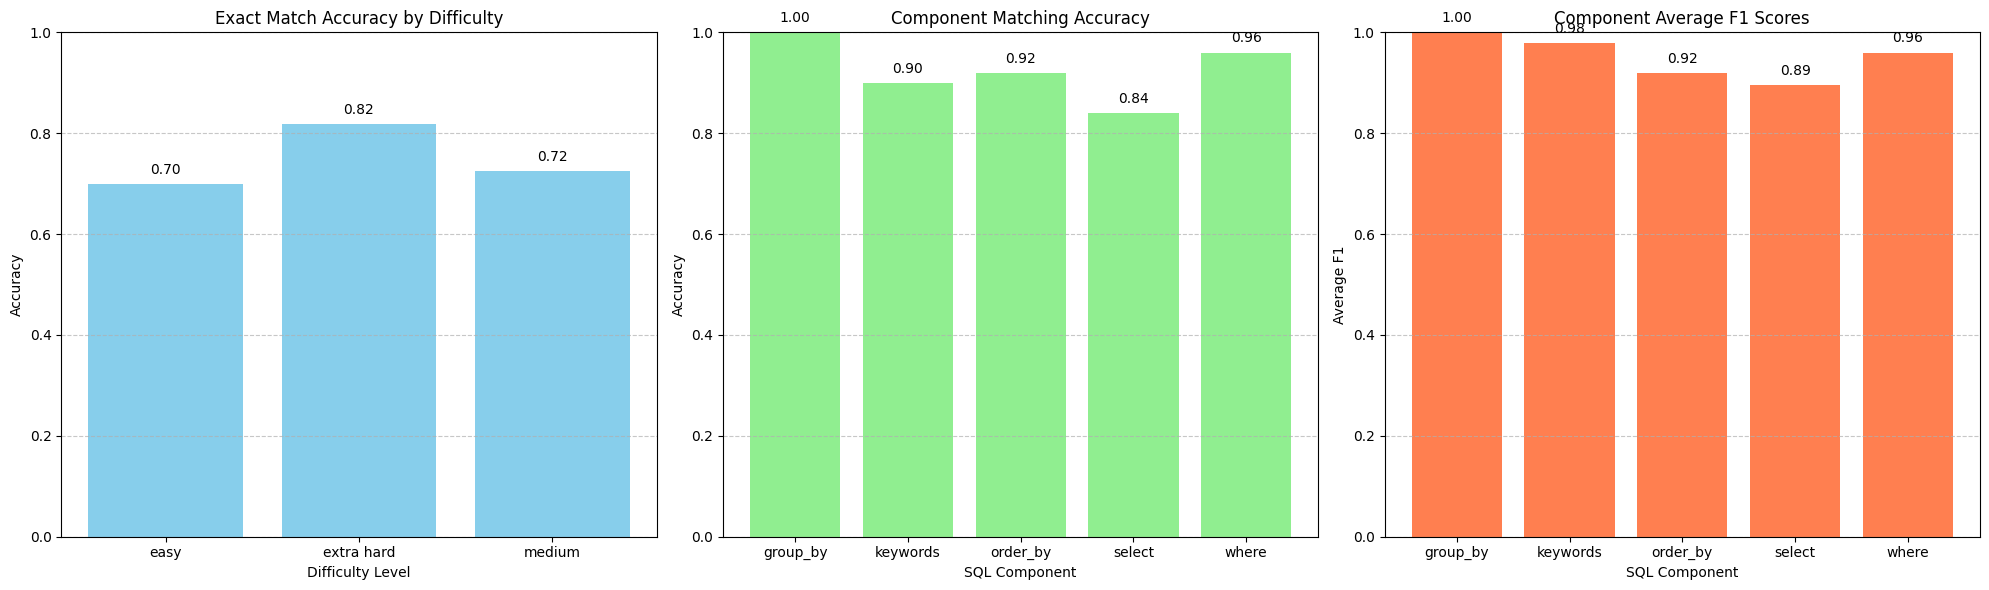


Detailed Prediction Results:


Difficulty,Exact Match,Question,Predicted SQL,Gold SQL
easy,True,How many singers do we have?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
easy,True,What is the total number of singers?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
medium,True,"Show name, country, age for all singers ordered by age from the oldest to the youngest.","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What are the names, countries, and ages for every singer in descending order of age?","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What is the average, minimum, and maximum age of all singers from France?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,True,"What is the average, minimum, and maximum age for all French singers?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,False,Show the name and the release year of the song by the youngest singer.,"SELECT T2.Name, T2.release_year FROM singer AS T1 JOIN song AS T2 ON T1.song_id = T2.song_id ORDER BY T1.age LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
medium,False,What are the names and release years for all the songs of the youngest singer?,"SELECT Song_Name, Release_Year FROM singer ORDER BY Age ASC LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
easy,False,What are all distinct countries where singers above age 20 are from?,SELECT DISTINCT T1.country FROM singer AS T1 JOIN singer_in_match AS T2 ON T1.song_id = T2.song_id WHERE T2.age > 20,SELECT DISTINCT country FROM singer WHERE age > 20
easy,True,What are the different countries with singers above age 20?,SELECT DISTINCT country FROM singer WHERE age > 20,SELECT DISTINCT country FROM singer WHERE age > 20


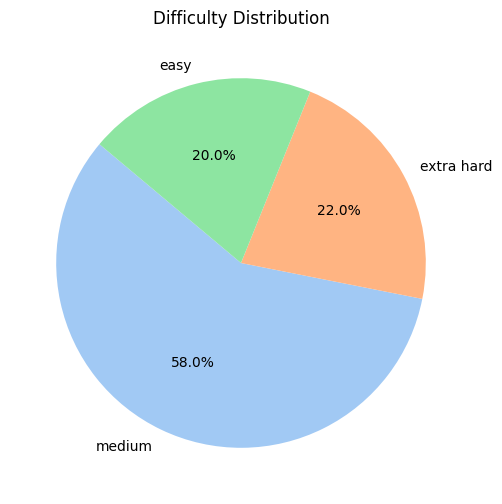

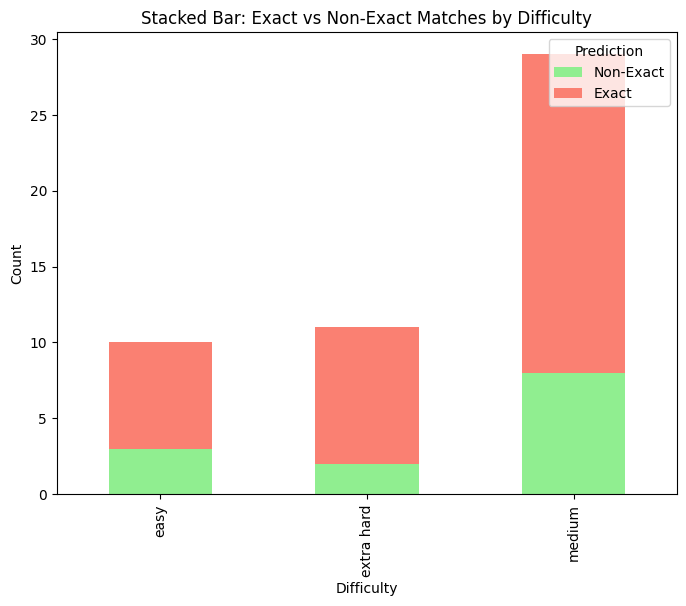

<ipython-input-11-bafb6eec6c16>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='difficulty', y='question_length', data=res_df, palette='Set3')


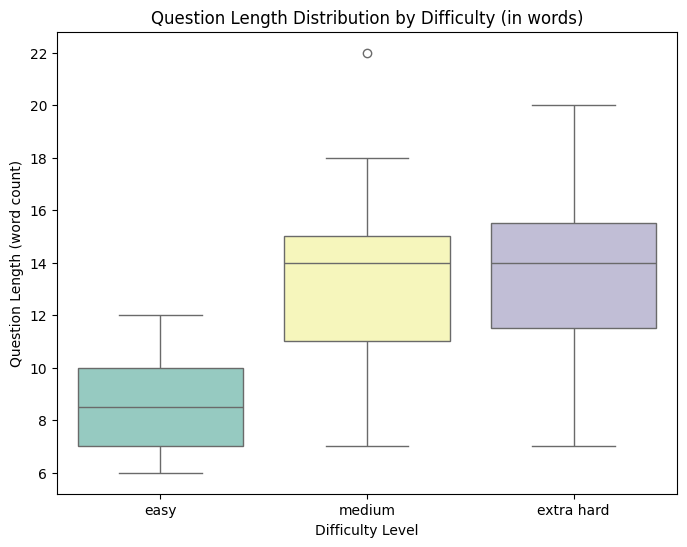

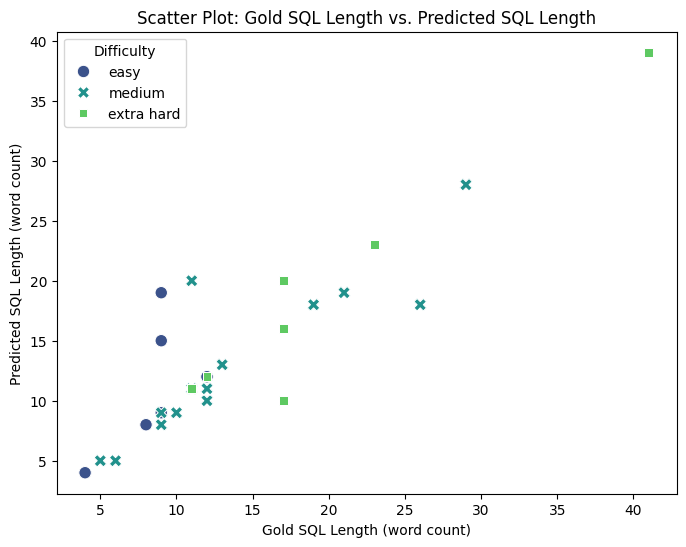

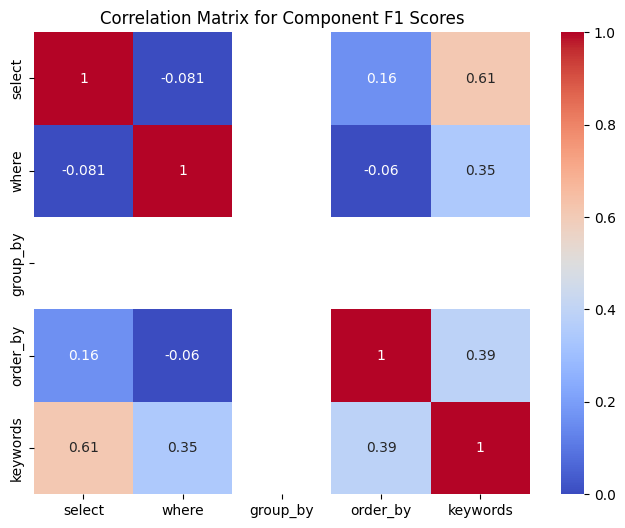

<Figure size 1000x600 with 0 Axes>

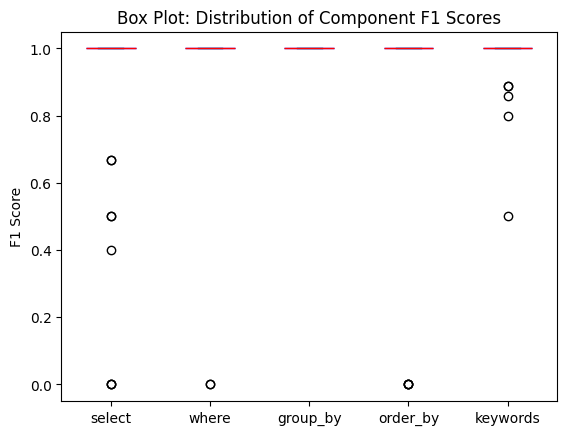

========================================   no of exampeles : 50
========================================   no of exampeles : 100
THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE:  100
Starting evaluation on 100 examples...
Processing example 1/100
Processing example 11/100
Processing example 21/100
Processing example 31/100
Processing example 41/100
Processing example 51/100
Processing example 61/100
Processing example 71/100
Processing example 81/100
Processing example 91/100

Exact Match Accuracy by Difficulty Level:


Difficulty,Count,Exact Matches,Accuracy
easy,16,11,0.6875
extra hard,23,13,0.5652
medium,61,27,0.4426



Component Matching Accuracy:


Component,Count,Matches,Accuracy
group_by,100,100,1.0000
keywords,100,74,0.7400
order_by,100,94,0.9400
select,100,73,0.7300
where,100,98,0.9800



Component Average F1 Scores:


Component,Average F1
group_by,1.0000
keywords,0.9552
order_by,0.9400
select,0.8110
where,0.9800



Overall Exact Match Accuracy: 0.5100 (51/100)



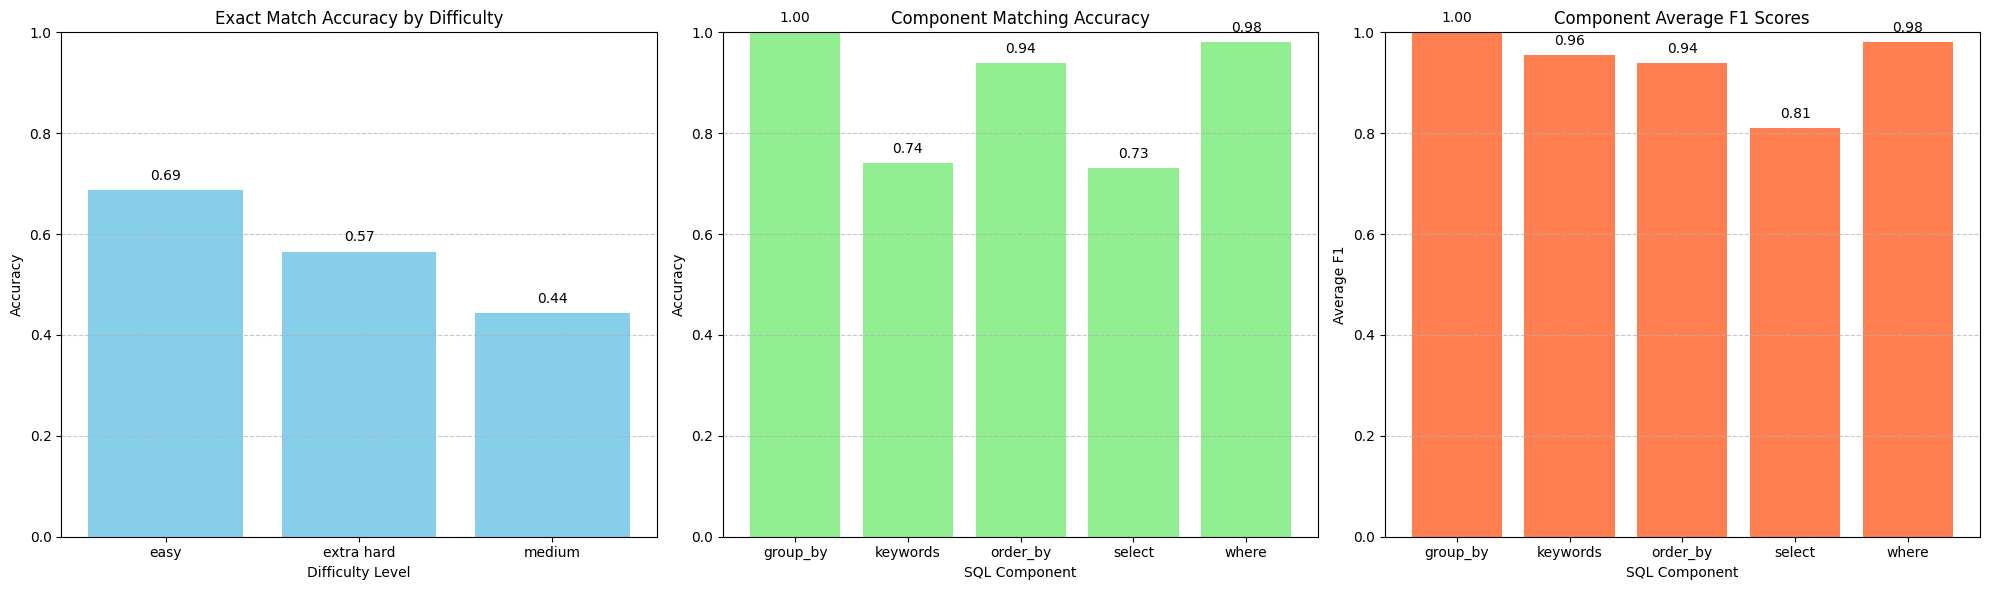


Detailed Prediction Results:


Difficulty,Exact Match,Question,Predicted SQL,Gold SQL
easy,True,How many singers do we have?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
easy,True,What is the total number of singers?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
medium,True,"Show name, country, age for all singers ordered by age from the oldest to the youngest.","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What are the names, countries, and ages for every singer in descending order of age?","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What is the average, minimum, and maximum age of all singers from France?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,True,"What is the average, minimum, and maximum age for all French singers?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,False,Show the name and the release year of the song by the youngest singer.,"SELECT T2.Name, T2.release_year FROM singer AS T1 JOIN song AS T2 ON T1.song_id = T2.song_id ORDER BY T1.age LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
medium,False,What are the names and release years for all the songs of the youngest singer?,"SELECT Song_Name, Release_Year FROM singer ORDER BY Age ASC LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
easy,False,What are all distinct countries where singers above age 20 are from?,SELECT DISTINCT T1.country FROM singer AS T1 JOIN singer_in_match AS T2 ON T1.song_id = T2.song_id WHERE T2.age > 20,SELECT DISTINCT country FROM singer WHERE age > 20
easy,True,What are the different countries with singers above age 20?,SELECT DISTINCT country FROM singer WHERE age > 20,SELECT DISTINCT country FROM singer WHERE age > 20


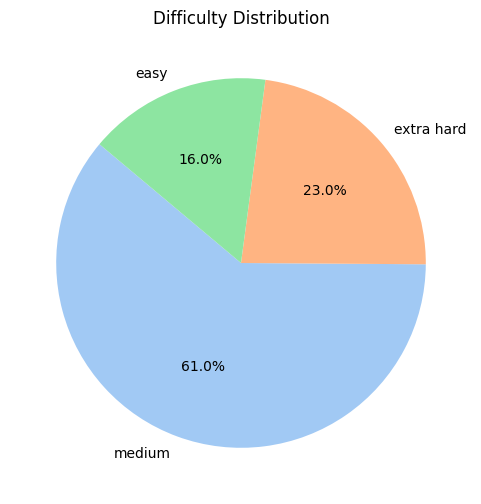

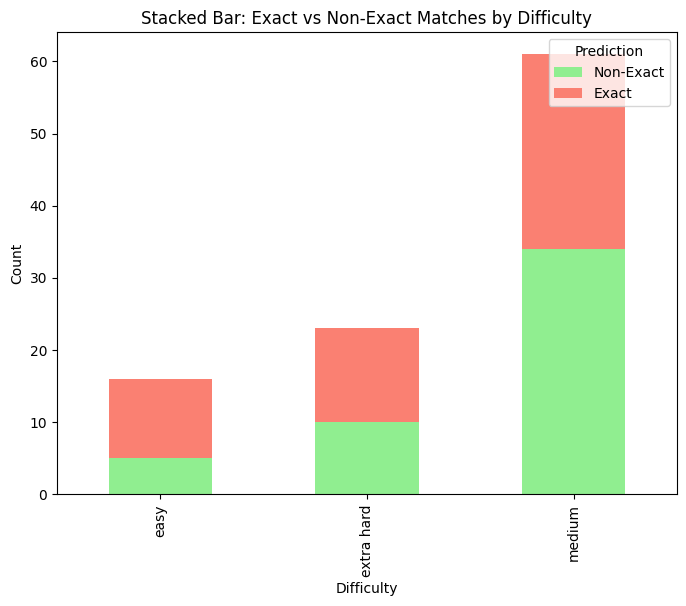

<ipython-input-11-bafb6eec6c16>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='difficulty', y='question_length', data=res_df, palette='Set3')


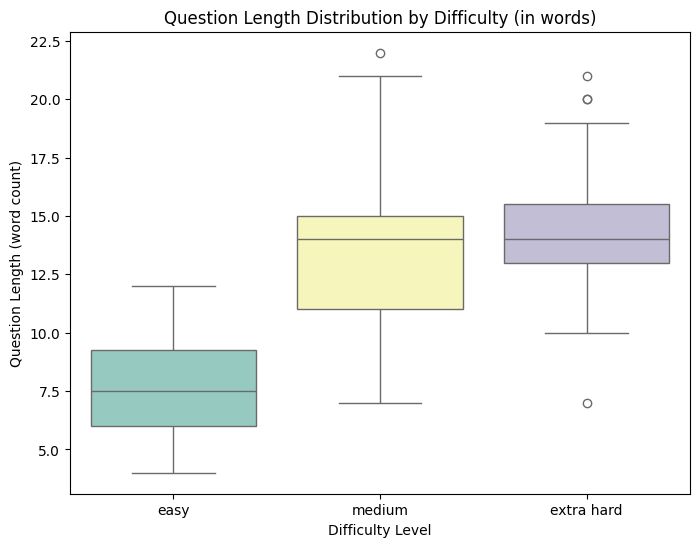

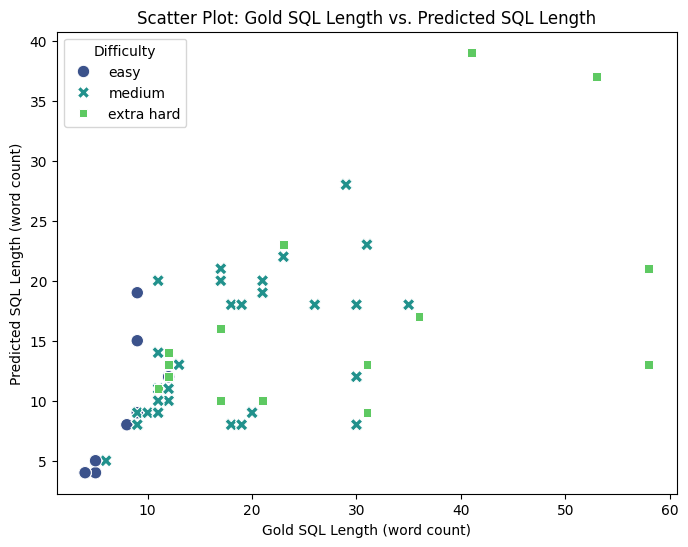

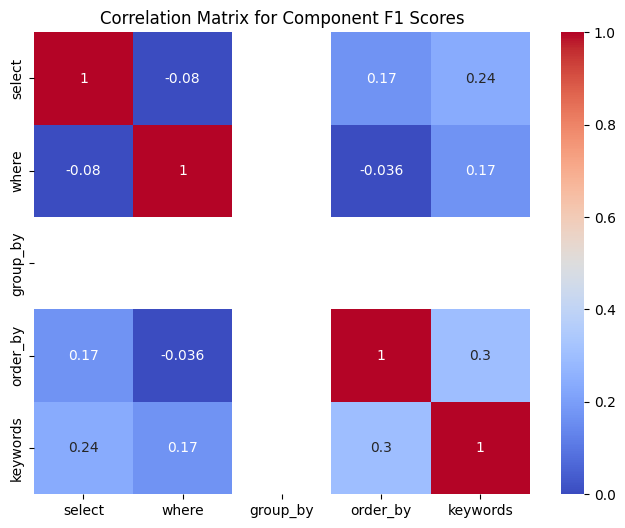

<Figure size 1000x600 with 0 Axes>

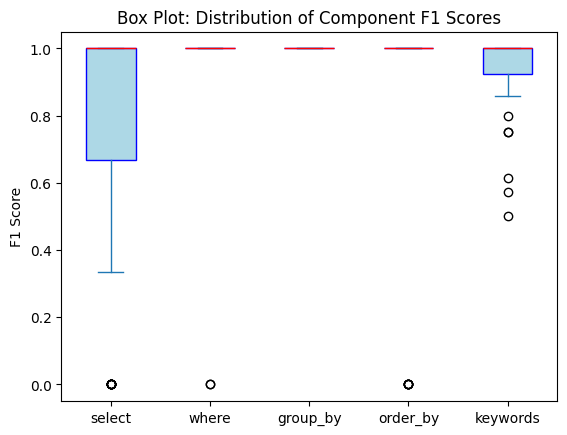

========================================   no of exampeles : 100
========================================   no of exampeles : 200
THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE:  200
Starting evaluation on 200 examples...
Processing example 1/200
Processing example 11/200
Processing example 21/200
Processing example 31/200
Processing example 41/200
Processing example 51/200
Processing example 61/200
Processing example 71/200
Processing example 81/200
Processing example 91/200
Processing example 101/200
Processing example 111/200
Processing example 121/200
Processing example 131/200
Processing example 141/200
Processing example 151/200
Processing example 161/200
Processing example 171/200
Processing example 181/200
Processing example 191/200

Exact Match Accuracy by Difficulty Level:


Difficulty,Count,Exact Matches,Accuracy
easy,51,32,0.6275
extra hard,35,13,0.3714
medium,114,35,0.3070



Component Matching Accuracy:


Component,Count,Matches,Accuracy
group_by,200,183,0.9150
keywords,200,136,0.6800
order_by,200,181,0.9050
select,200,117,0.5850
where,200,189,0.9450



Component Average F1 Scores:


Component,Average F1
group_by,0.9150
keywords,0.9373
order_by,0.9050
select,0.6490
where,0.9450



Overall Exact Match Accuracy: 0.4000 (80/200)



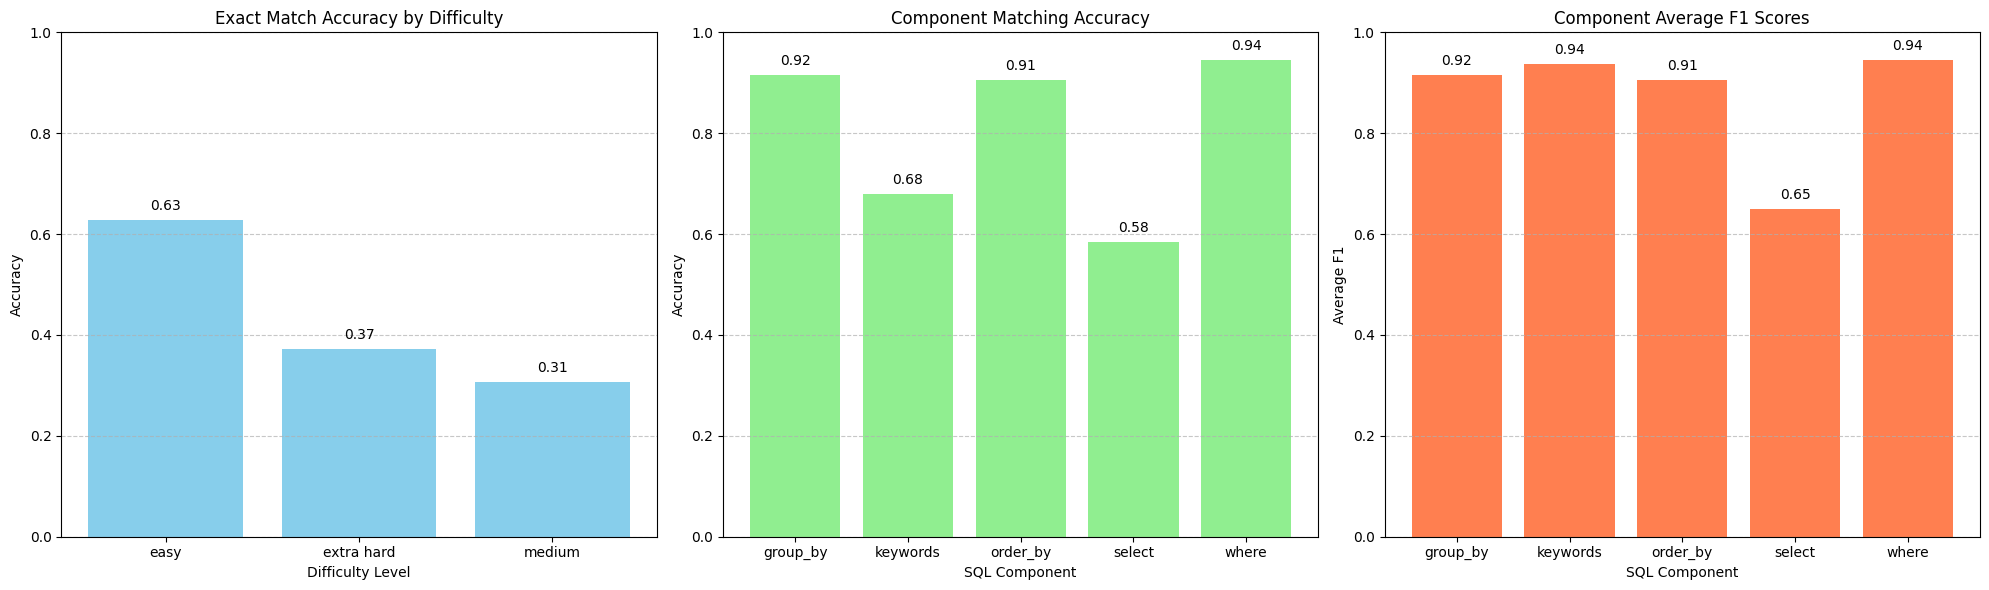


Detailed Prediction Results:


Difficulty,Exact Match,Question,Predicted SQL,Gold SQL
easy,True,How many singers do we have?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
easy,True,What is the total number of singers?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
medium,True,"Show name, country, age for all singers ordered by age from the oldest to the youngest.","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What are the names, countries, and ages for every singer in descending order of age?","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What is the average, minimum, and maximum age of all singers from France?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,True,"What is the average, minimum, and maximum age for all French singers?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,False,Show the name and the release year of the song by the youngest singer.,"SELECT T2.Name, T2.release_year FROM singer AS T1 JOIN song AS T2 ON T1.song_id = T2.song_id ORDER BY T1.age LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
medium,False,What are the names and release years for all the songs of the youngest singer?,"SELECT Song_Name, Release_Year FROM singer ORDER BY Age ASC LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
easy,False,What are all distinct countries where singers above age 20 are from?,SELECT DISTINCT T1.country FROM singer AS T1 JOIN singer_in_match AS T2 ON T1.song_id = T2.song_id WHERE T2.age > 20,SELECT DISTINCT country FROM singer WHERE age > 20
easy,True,What are the different countries with singers above age 20?,SELECT DISTINCT country FROM singer WHERE age > 20,SELECT DISTINCT country FROM singer WHERE age > 20


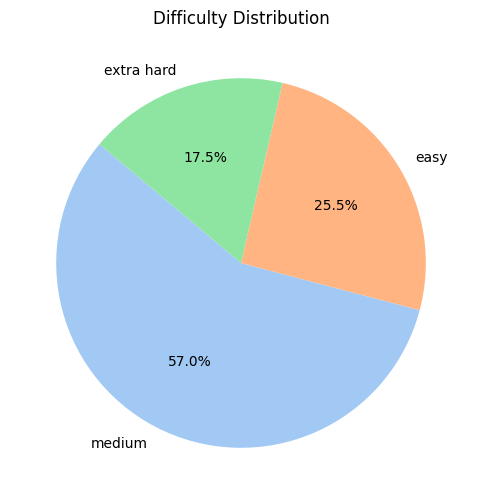

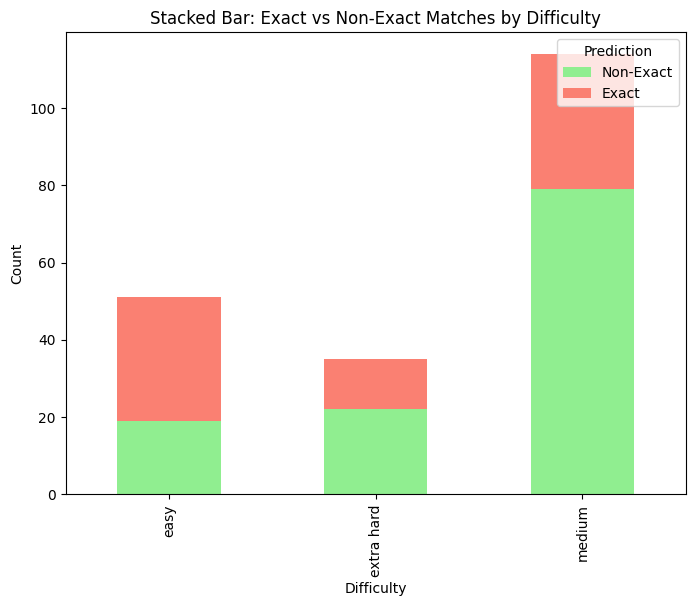

<ipython-input-11-bafb6eec6c16>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='difficulty', y='question_length', data=res_df, palette='Set3')


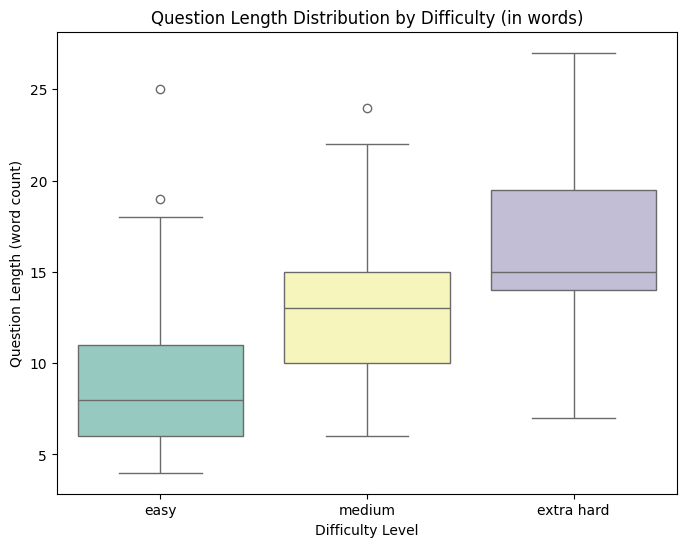

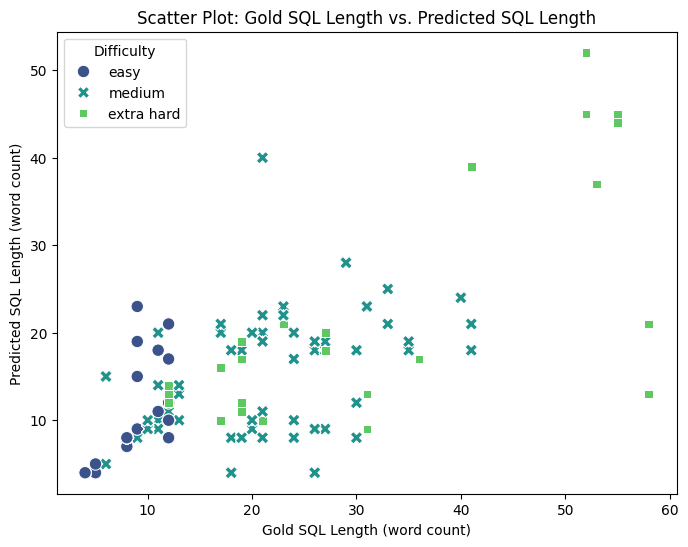

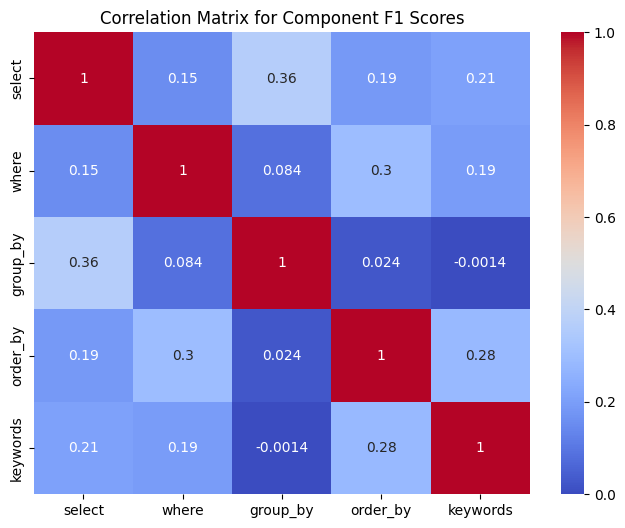

<Figure size 1000x600 with 0 Axes>

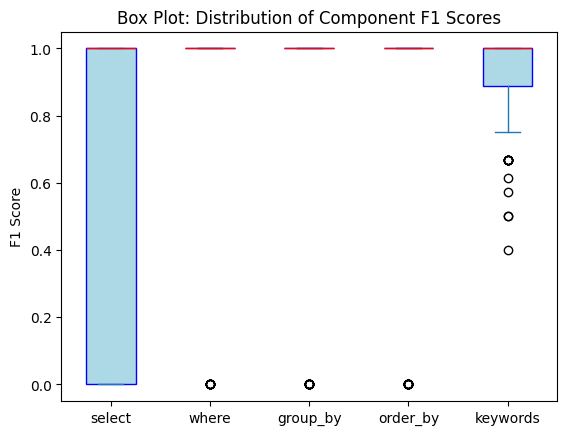

========================================   no of exampeles : 200
========================================   no of exampeles : 500
THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE:  500
Starting evaluation on 500 examples...
Processing example 1/500
Processing example 11/500
Processing example 21/500
Processing example 31/500
Processing example 41/500
Processing example 51/500
Processing example 61/500
Processing example 71/500
Processing example 81/500
Processing example 91/500
Processing example 101/500
Processing example 111/500
Processing example 121/500
Processing example 131/500
Processing example 141/500
Processing example 151/500
Processing example 161/500
Processing example 171/500
Processing example 181/500
Processing example 191/500
Processing example 201/500
Processing example 211/500
Processing example 221/500
Processing example 231/500
Processing example 241/500
Processing example 251/500
Processing example 261/500
Processing example 271/500
Processing example 281/500
Process

Difficulty,Count,Exact Matches,Accuracy
easy,127,79,0.6220
extra hard,65,30,0.4615
medium,308,113,0.3669



Component Matching Accuracy:


Component,Count,Matches,Accuracy
group_by,500,449,0.8980
keywords,500,343,0.6860
order_by,500,461,0.9220
select,500,312,0.6240
where,500,481,0.9620



Component Average F1 Scores:


Component,Average F1
group_by,0.8980
keywords,0.9441
order_by,0.9220
select,0.6783
where,0.9620



Overall Exact Match Accuracy: 0.4440 (222/500)



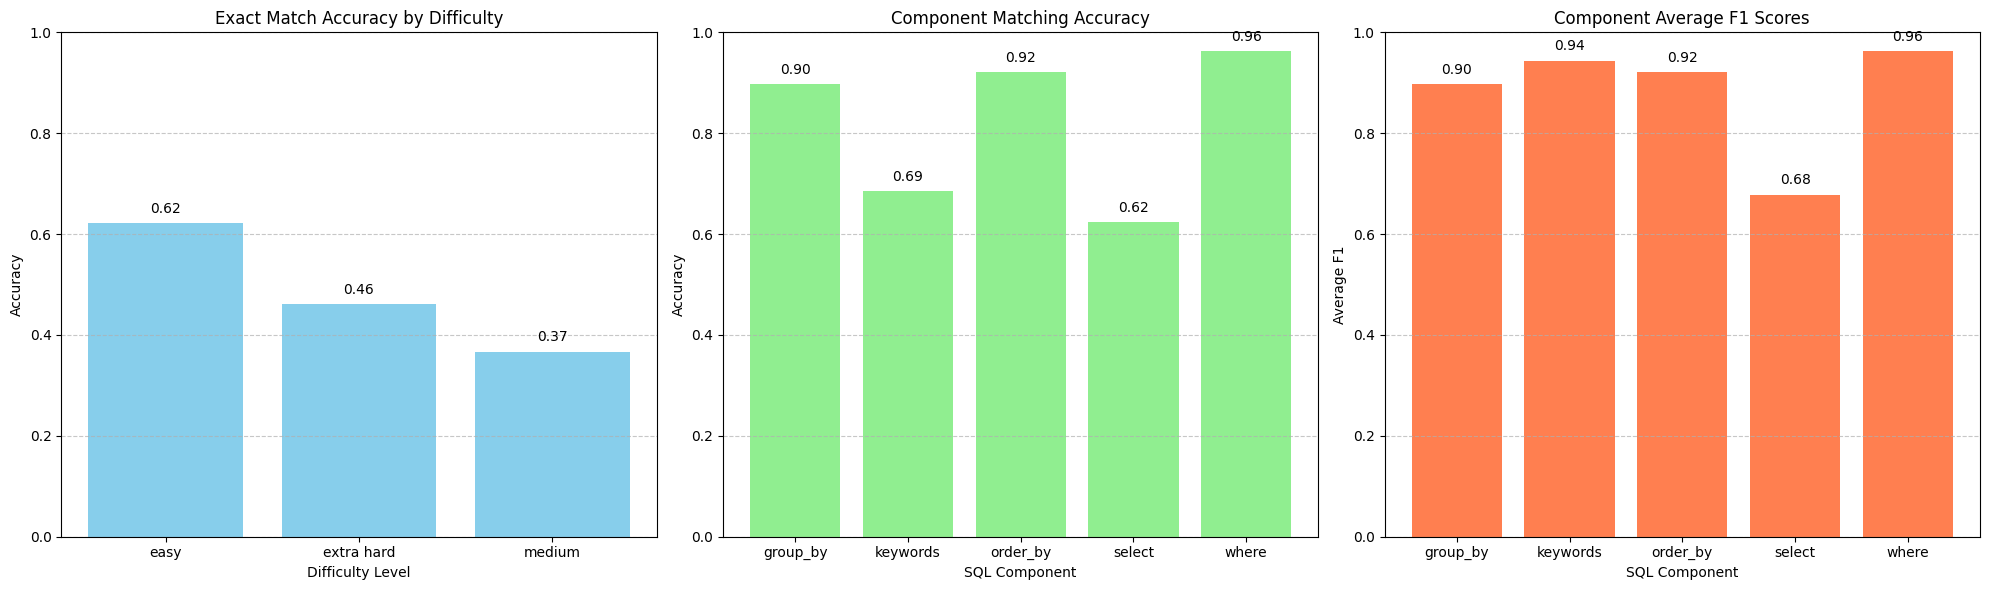


Detailed Prediction Results:


Difficulty,Exact Match,Question,Predicted SQL,Gold SQL
easy,True,How many singers do we have?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
easy,True,What is the total number of singers?,SELECT count(*) FROM singer,SELECT count(*) FROM singer
medium,True,"Show name, country, age for all singers ordered by age from the oldest to the youngest.","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What are the names, countries, and ages for every singer in descending order of age?","SELECT name, country, age FROM singer ORDER BY age DESC","SELECT name , country , age FROM singer ORDER BY age DESC"
medium,True,"What is the average, minimum, and maximum age of all singers from France?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,True,"What is the average, minimum, and maximum age for all French singers?","SELECT avg(age), min(age), max(age) FROM singer WHERE country = 'France'","SELECT avg(age) , min(age) , max(age) FROM singer WHERE country = 'France'"
medium,False,Show the name and the release year of the song by the youngest singer.,"SELECT T2.Name, T2.release_year FROM singer AS T1 JOIN song AS T2 ON T1.song_id = T2.song_id ORDER BY T1.age LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
medium,False,What are the names and release years for all the songs of the youngest singer?,"SELECT Song_Name, Release_Year FROM singer ORDER BY Age ASC LIMIT 1","SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
easy,False,What are all distinct countries where singers above age 20 are from?,SELECT DISTINCT T1.country FROM singer AS T1 JOIN singer_in_match AS T2 ON T1.song_id = T2.song_id WHERE T2.age > 20,SELECT DISTINCT country FROM singer WHERE age > 20
easy,True,What are the different countries with singers above age 20?,SELECT DISTINCT country FROM singer WHERE age > 20,SELECT DISTINCT country FROM singer WHERE age > 20


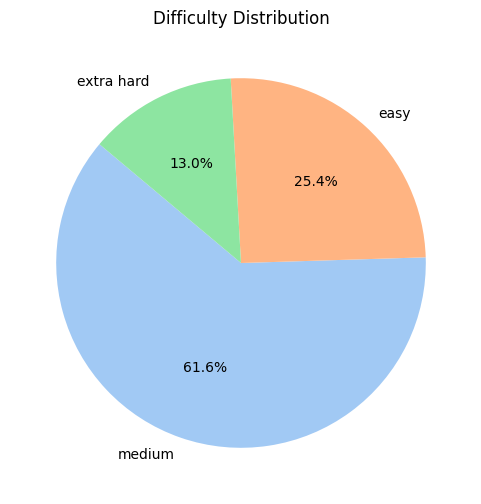

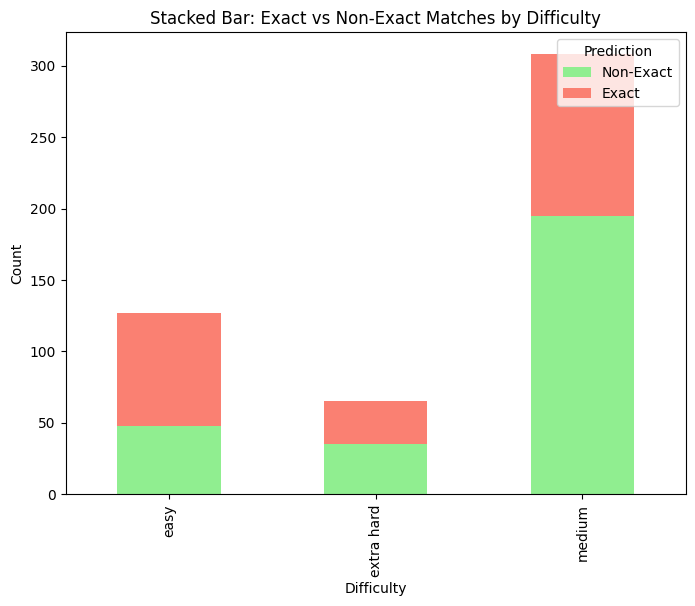

<ipython-input-11-bafb6eec6c16>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='difficulty', y='question_length', data=res_df, palette='Set3')


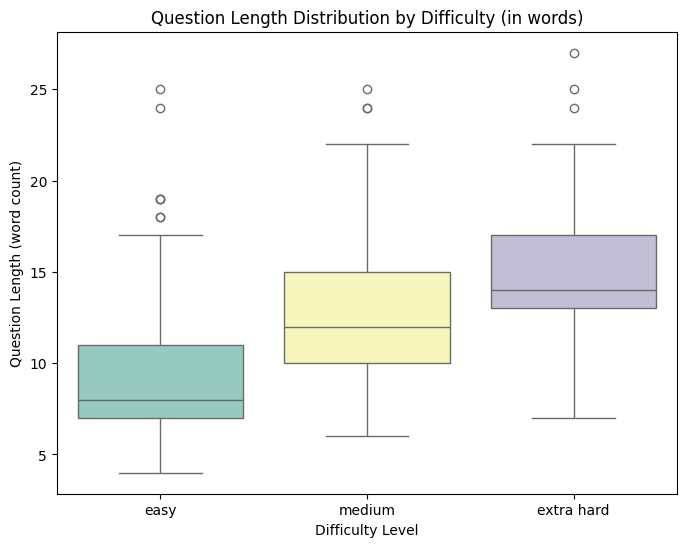

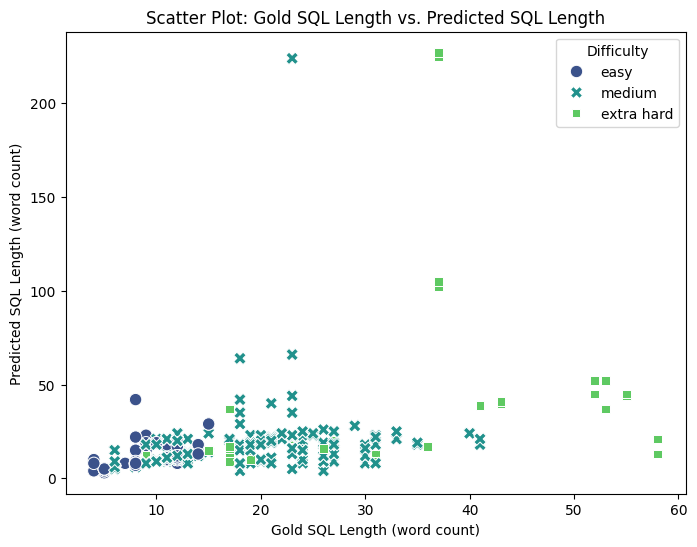

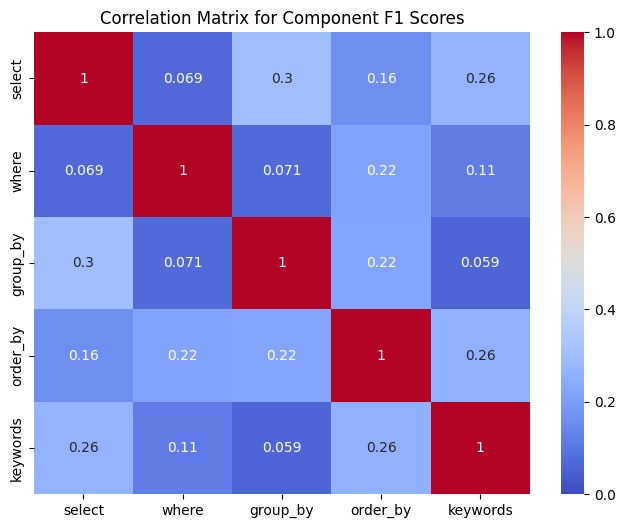

<Figure size 1000x600 with 0 Axes>

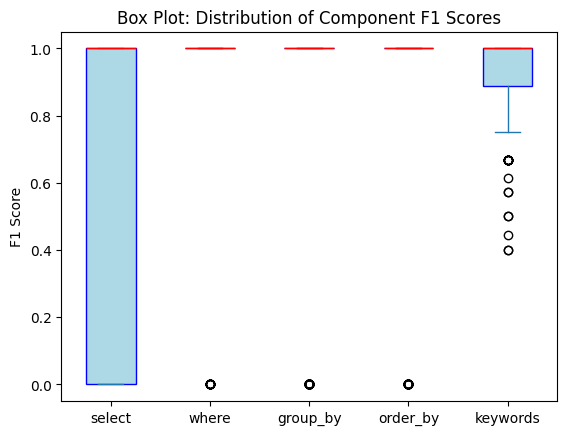

========================================   no of exampeles : 500
========================================   no of exampeles : 750
THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE:  750
Starting evaluation on 750 examples...
Processing example 1/750
Processing example 11/750
Processing example 21/750
Processing example 31/750
Processing example 41/750
Processing example 51/750
Processing example 61/750
Processing example 71/750
Processing example 81/750
Processing example 91/750
Processing example 101/750
Processing example 111/750
Processing example 121/750
Processing example 131/750
Processing example 141/750
Processing example 151/750
Processing example 161/750
Processing example 171/750
Processing example 181/750
Processing example 191/750
Processing example 201/750
Processing example 211/750
Processing example 221/750
Processing example 231/750
Processing example 241/750
Processing example 251/750
Processing example 261/750
Processing example 271/750
Processing example 281/750
Process

In [ ]:
# num_examples = 50,100,200,500,1000,1034 # analysis type 1
total_num = [50,100,200,500,750,1000,1034]
for i in total_num:
    print("="*40,"  no of exampeles :" ,i)
    print('THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE: ' ,i)
    results = evaluate_model_pretty(model, tokenizer, dev_data, device, num_examples=i)
    show(results)
    print("="*40,"  no of exampeles :" ,i)


In [ ]:
# num_examples = 50,100,200,500,1000,1034  # analysis type 2
total_num = [50,100,200,500,750,1000,1034]
for i in total_num:
    print("="*40,"  no of exampeles :" ,i)
    print('THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE: ' ,i)
    results = evaluate_model_pretty2(model, tokenizer, dev_data, device, num_examples=i)
    show(results)
    print("="*40,"  no of exampeles :" ,i)


In [ ]:
# num_examples = 50,100,200,500,1000,1034  # analysis type 2
total_num = [50,100,200,500,750,1000,1034]
for i in total_num:
    print("="*40,"  no of exampeles :" ,i)
    print('THE NUMBER OF EXAMPLES USED FROM DEV_DATA ARE: ' ,i)
    results = evaluate_model_pretty3(model, tokenizer, dev_data, device, num_examples=i)
    show(results)
    print("="*40,"  no of exampeles :" ,i)
